In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
# authenticate
auth.authenticate_user()

In [ ]:
# Set up environment variables
project_id = 'project-mimic-430923'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

In [ ]:
# 1. Get basic patient info (admissions + demographics (excluding marital_status) + death status)
patient_info_query = """
SELECT adm.subject_id, adm.hadm_id, adm.admittime, adm.dischtime, pat.gender, pat.anchor_age AS age, adm.race, adm.hospital_expire_flag
FROM `physionet-data.mimiciv_hosp.admissions` AS adm
JOIN `physionet-data.mimiciv_hosp.patients` AS pat
ON adm.subject_id = pat.subject_id
WHERE adm.admittime IS NOT NULL
ORDER BY subject_id
"""
patient_info_df = run_query(patient_info_query)

patient_info_df['in_hospital_death'] = patient_info_df['hospital_expire_flag'] == 1

patient_info_df = patient_info_df.drop(columns=['hospital_expire_flag'])

# Calculate length of stay and have data only with positive L.O.F
patient_info_df['admittime'] = pd.to_datetime(patient_info_df['admittime'])
patient_info_df['dischtime'] = pd.to_datetime(patient_info_df['dischtime'])
patient_info_df['length_of_stay'] = (patient_info_df['dischtime'] - patient_info_df['admittime']).dt.total_seconds() / (60 * 60 * 24)

patient_info_df = patient_info_df[patient_info_df['length_of_stay'] > 0]

<ipython-input-3-d70a68234fd1>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [ ]:
patient_info_df

,subject_id,hadm_id,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay
0,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,F,52,WHITE,False,1.015278
1,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,F,52,WHITE,False,2.222222
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,F,52,WHITE,False,1.754167
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,F,52,WHITE,False,0.786111
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,F,19,WHITE,False,0.298611
...,...,...,...,...,...,...,...,...,...
431226,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,F,46,WHITE,False,17.074306
431227,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,F,46,WHITE,False,10.011111
431228,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,M,58,WHITE,False,3.491667
431229,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,M,58,WHITE,True,6.996528


In [ ]:
# Count number of patients
num_patients = patient_info_df['subject_id'].nunique()
print(f"Number of patients: {num_patients}")

Number of patients: 180677


In [ ]:
ap_icd_code_query = f"""
SELECT icd_code, long_title, icd_version
FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
WHERE icd_code = '5770' or icd_code LIKE 'K85%'
ORDER BY icd_code
"""
ap_icd_code_df = run_query(ap_icd_code_query)

<ipython-input-5-d70a68234fd1>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [ ]:
ap_icd_code_df

,icd_code,long_title,icd_version
0,5770,Acute pancreatitis,9
1,K85,Acute pancreatitis,10
2,K850,Idiopathic acute pancreatitis,10
3,K8500,Idiopathic acute pancreatitis without necrosis...,10
4,K8501,Idiopathic acute pancreatitis with uninfected ...,10
5,K8502,Idiopathic acute pancreatitis with infected ne...,10
6,K851,Biliary acute pancreatitis,10
7,K8510,Biliary acute pancreatitis without necrosis or...,10
8,K8511,Biliary acute pancreatitis with uninfected nec...,10
9,K8512,Biliary acute pancreatitis with infected necrosis,10


In [ ]:
ap_icd_query = f"""
SELECT subject_id, hadm_id, icd_code
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code LIKE 'K85%' or icd_code = '5770'
ORDER BY subject_id
"""
ap_icd_df = run_query(ap_icd_query)

<ipython-input-5-d70a68234fd1>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [ ]:
ap_icd_df

,subject_id,hadm_id,icd_code
0,10002807,28464737,K8590
1,10004606,29242151,K8510
2,10006431,24638489,K8580
3,10007795,25135483,5770
4,10007795,28477357,5770
...,...,...,...
5889,19990545,23106222,K8590
5890,19993764,23707485,K851
5891,19996968,29843339,5770
5892,19996968,28227793,5770


In [ ]:
ap_icd_df['subject_id'].nunique()

3850

In [ ]:
merged_ap_icd_df = pd.merge(patient_info_df, ap_icd_df[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

In [ ]:
merged_ap_icd_df

,subject_id,hadm_id,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay
0,10002807,28464737,2152-03-30 16:09:00,2152-03-31 08:20:00,M,57,BLACK/AFRICAN AMERICAN,False,0.674306
1,10004606,29242151,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556
2,10006431,24638489,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,False,6.654167
3,10007795,28477357,2136-04-10 20:33:00,2136-05-02 16:35:00,F,53,WHITE,False,21.834722
4,10007795,25135483,2136-05-04 20:20:00,2136-05-12 17:12:00,F,53,WHITE,False,7.869444
...,...,...,...,...,...,...,...,...,...
5888,19990545,23106222,2139-10-04 23:11:00,2139-10-29 15:45:00,F,43,ASIAN - ASIAN INDIAN,False,24.690278
5889,19993764,23707485,2167-08-27 23:09:00,2167-08-30 16:38:00,M,76,WHITE,False,2.728472
5890,19996968,28227793,2125-02-18 16:48:00,2125-02-22 10:45:00,M,32,BLACK/AFRICAN AMERICAN,False,3.747917
5891,19996968,29843339,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,False,2.725694


In [ ]:
# Count the number of patients with high lipase levels who had a CT scan
num_ap_icd_df = merged_ap_icd_df['subject_id'].nunique()
print(f"Number of patients with high lipase levels who had a CT scan: {num_ap_icd_df}")

# Count the number of rows in the dataset
num_rows = merged_ap_icd_df.shape[0]
print(f"Number of rows in the dataset: {num_rows}")

Number of patients with high lipase levels who had a CT scan: 3849
Number of rows in the dataset: 5893


In [ ]:
def select_row(group):
    # Check if there's any row with hospital_expire_flag = 1
    if (group['in_hospital_death']).any():
        # Return the first row with hospital_expire_flag = 1
        return group[group['in_hospital_death']].iloc[0]
    else:
        # Otherwise, return the row with the maximum length_of_stay
        return group.loc[group['length_of_stay'].idxmax()]

# Apply the function to each group and reset the index
ap_filtered_df = merged_ap_icd_df.groupby(['subject_id']).apply(select_row).reset_index(drop=True)

<ipython-input-167-c3d881ddbe33>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ap_filtered_df = merged_ap_icd_df.groupby(['subject_id']).apply(select_row).reset_index(drop=True)


In [ ]:
ap_filtered_df

,subject_id,hadm_id,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay
0,10002807,28464737,2152-03-30 16:09:00,2152-03-31 08:20:00,M,57,BLACK/AFRICAN AMERICAN,False,0.674306
1,10004606,29242151,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556
2,10006431,24638489,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,False,6.654167
3,10007795,28477357,2136-04-10 20:33:00,2136-05-02 16:35:00,F,53,WHITE,False,21.834722
4,10007920,23867410,2138-12-28 02:56:00,2139-01-01 15:00:00,M,52,WHITE,False,4.502778
...,...,...,...,...,...,...,...,...,...
3844,19987216,26152159,2184-02-07 05:30:00,2184-02-12 14:27:00,M,48,WHITE,False,5.372917
3845,19990545,23106222,2139-10-04 23:11:00,2139-10-29 15:45:00,F,43,ASIAN - ASIAN INDIAN,False,24.690278
3846,19993764,23707485,2167-08-27 23:09:00,2167-08-30 16:38:00,M,76,WHITE,False,2.728472
3847,19996968,28227793,2125-02-18 16:48:00,2125-02-22 10:45:00,M,32,BLACK/AFRICAN AMERICAN,False,3.747917


In [ ]:
ap_filtered_df.to_csv('AP_ICD_Dataset.csv', encoding='utf-8', index = False)

In [ ]:
# 5. Retrieve comorbid conditions (ICD codes)
hadm_ids = ', '.join(str(hadm_id) for hadm_id in ap_filtered_df['hadm_id'].unique())
comorbidity_query = f"""
SELECT subject_id, hadm_id, icd_code, seq_num, icd_version
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE hadm_id IN ({hadm_ids})
ORDER BY subject_id, hadm_id, seq_num
"""
comorbidities_df = run_query(comorbidity_query)

# Merge comorbidities with the dataset
merged_comorbidities_df = pd.merge(ap_filtered_df, comorbidities_df, on=['subject_id', 'hadm_id'], how='left')

# Display the final merged dataset
print(merged_comorbidities_df.head())

<ipython-input-5-d70a68234fd1>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


   subject_id   hadm_id           admittime           dischtime gender  age  \
0    10002807  28464737 2152-03-30 16:09:00 2152-03-31 08:20:00      M   57   
1    10002807  28464737 2152-03-30 16:09:00 2152-03-31 08:20:00      M   57   
2    10002807  28464737 2152-03-30 16:09:00 2152-03-31 08:20:00      M   57   
3    10002807  28464737 2152-03-30 16:09:00 2152-03-31 08:20:00      M   57   
4    10002807  28464737 2152-03-30 16:09:00 2152-03-31 08:20:00      M   57   

                     race  in_hospital_death  length_of_stay icd_code  \
0  BLACK/AFRICAN AMERICAN              False        0.674306    K8590   
1  BLACK/AFRICAN AMERICAN              False        0.674306    I2510   
2  BLACK/AFRICAN AMERICAN              False        0.674306      I10   
3  BLACK/AFRICAN AMERICAN              False        0.674306     E785   
4  BLACK/AFRICAN AMERICAN              False        0.674306     K219   

   seq_num  icd_version  
0        1           10  
1        2           10  
2       

In [ ]:
merged_comorbidities_df.to_csv('AP_ICD_Comorbidities_Dataset.csv', encoding='utf-8', index = False)

In [ ]:
# Count the number of unique patients who died in the hospital
num_patients_with_death_info = merged_comorbidities_df[merged_comorbidities_df['in_hospital_death'] == True][['subject_id', 'hadm_id']].drop_duplicates().shape[0]
print(f"Number of unique patients who died in the hospital: {num_patients_with_death_info}")

Number of unique patients who died in the hospital: 141


# EDA

In [ ]:
# 1. Handle missing values
missing_data = merged_comorbidities_df.isnull().sum()
print(missing_data)

subject_id           0
hadm_id              0
admittime            0
dischtime            0
gender               0
age                  0
race                 0
in_hospital_death    0
length_of_stay       0
icd_code             0
seq_num              0
icd_version          0
dtype: int64


In [ ]:
# 2. Statistical summary
summary = ap_filtered_df.describe()
print(summary)

         subject_id       hadm_id                      admittime  \
count  3.849000e+03  3.849000e+03                           3849   
mean   1.499039e+07  2.498044e+07  2154-01-29 00:26:31.161340928   
min    1.000281e+07  2.000180e+07            2110-02-08 06:03:00   
25%    1.246071e+07  2.248702e+07            2133-11-22 22:53:00   
50%    1.496440e+07  2.494225e+07            2154-02-24 09:32:00   
75%    1.749877e+07  2.753961e+07            2174-02-04 10:40:00   
max    1.999844e+07  2.999855e+07            2209-09-13 06:44:00   
std    2.896381e+06  2.895583e+06                            NaN   

                           dischtime          age  length_of_stay  
count                           3849  3849.000000     3849.000000  
mean   2154-02-06 11:11:30.475448320    56.678618        8.447909  
min              2110-02-13 17:45:00    18.000000        0.107639  
25%              2133-11-27 12:28:00    44.000000        2.785417  
50%              2154-03-05 11:00:00    57.0000

In [ ]:
patient_info_df['subject_id'].nunique()

180677

In [ ]:
merged_ap_icd_df['subject_id'].nunique()

3849

In [ ]:
3849/180677

0.021303209595023163

In [ ]:
ap_filtered_df['gender'].value_counts()

,count
gender,
M,1952
F,1897


In [ ]:
ap_filtered_df['in_hospital_death'].value_counts()

,count
in_hospital_death,
False,3708
True,141


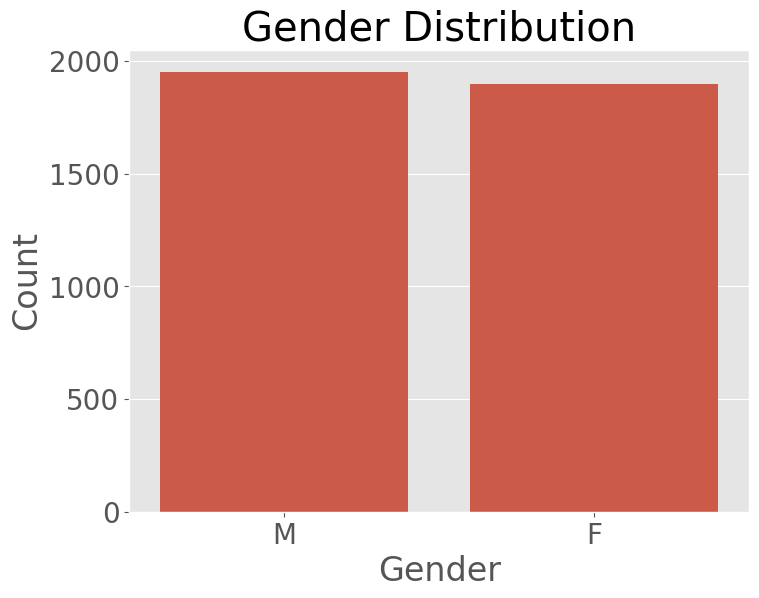

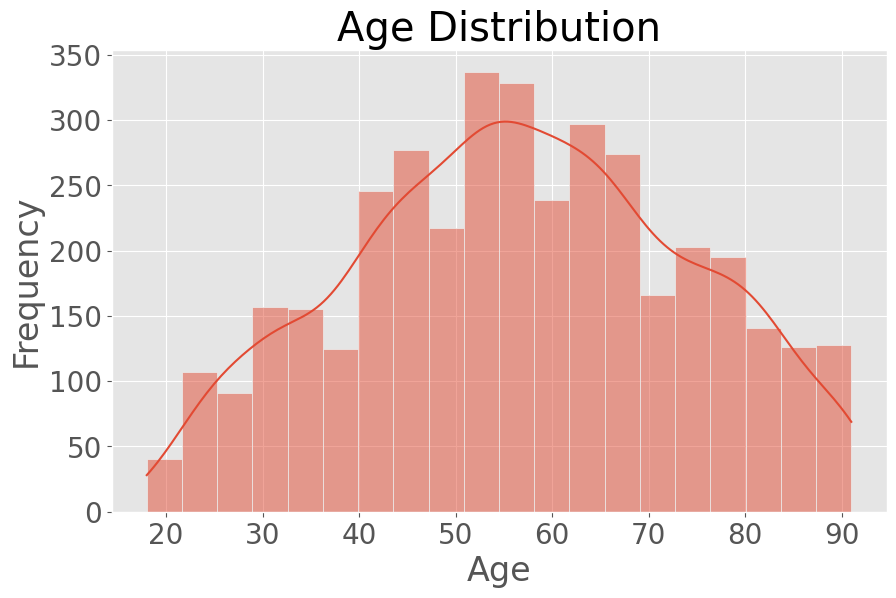

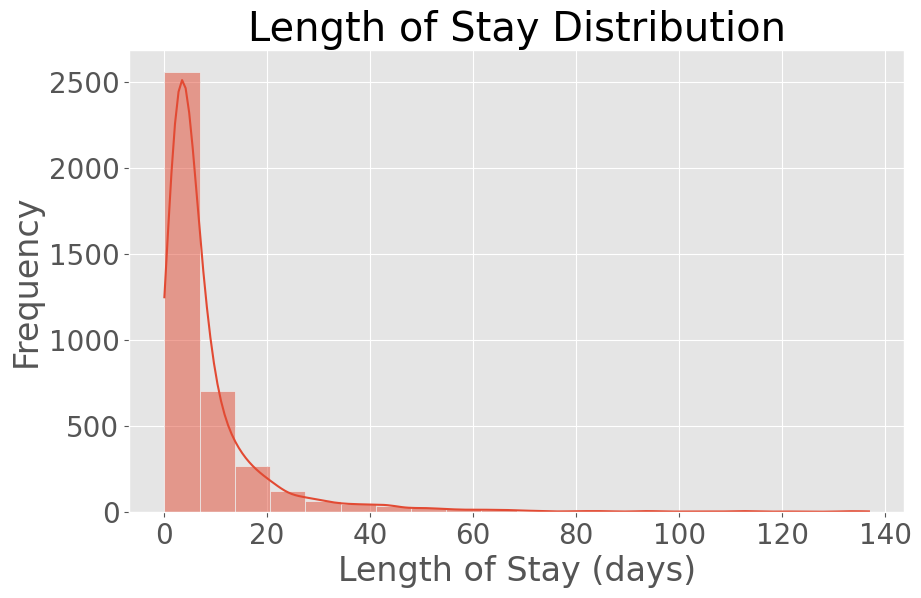

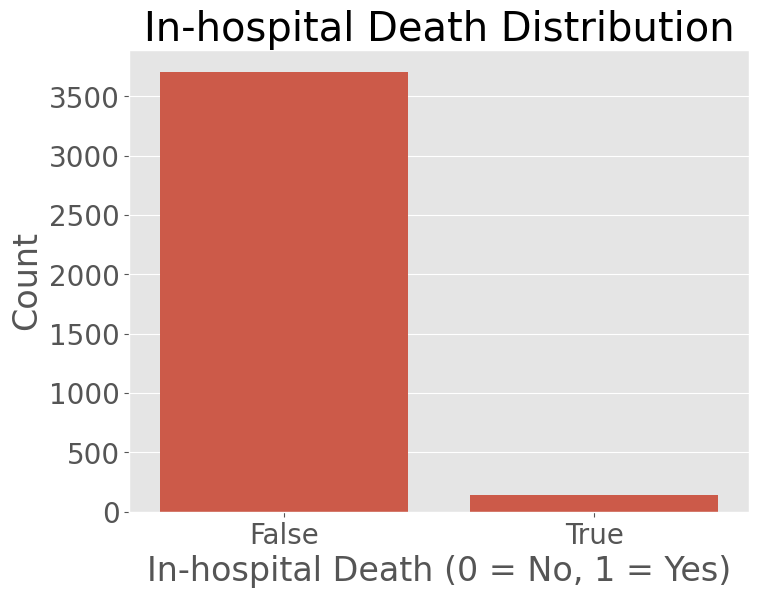

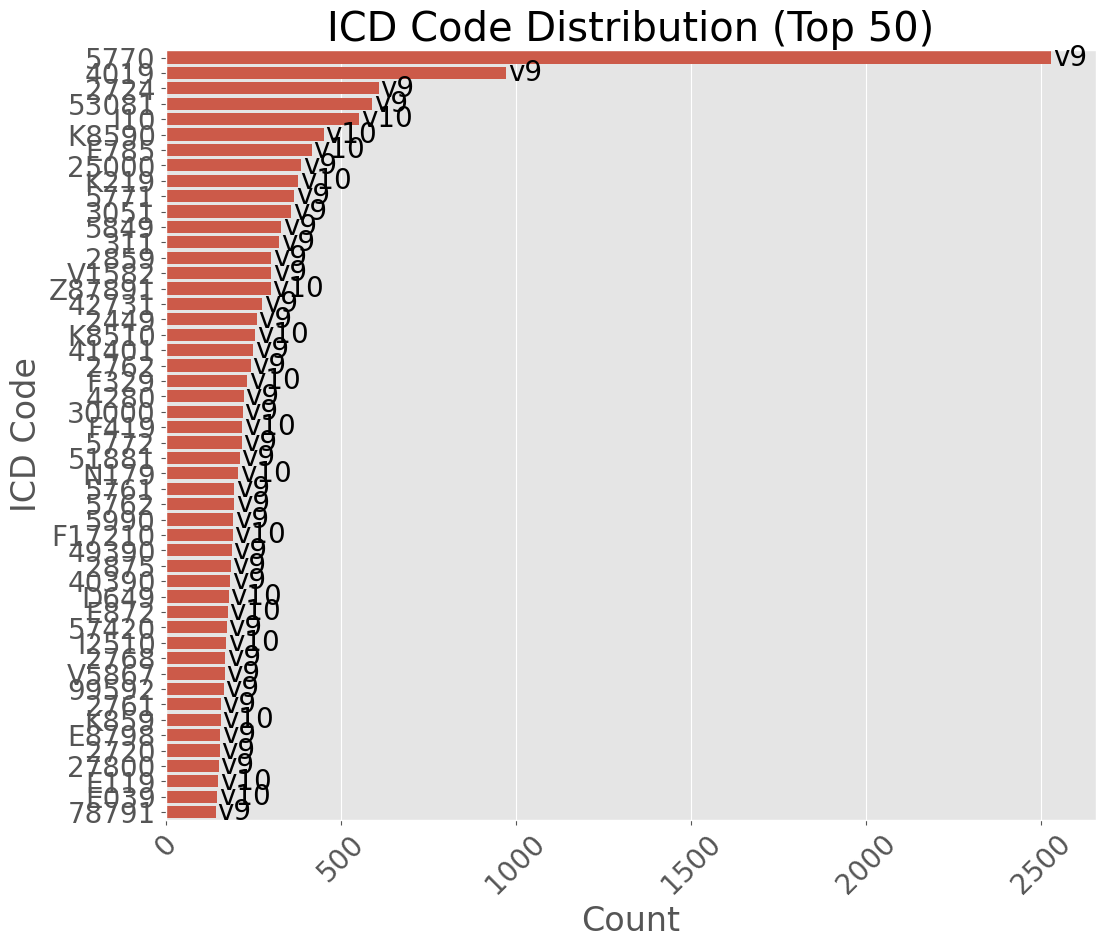

In [ ]:
# 3. visualize the distribution of vital data
import matplotlib.pyplot as plt
import seaborn as sns

# Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=ap_filtered_df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Age
plt.figure(figsize=(10, 6))
sns.histplot(ap_filtered_df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


# Length of stay
plt.figure(figsize=(10, 6))
sns.histplot(ap_filtered_df['length_of_stay'], bins=20, kde=True)
plt.title('Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()


# In-hospital death
plt.figure(figsize=(8, 6))
sns.countplot(x='in_hospital_death', data=ap_filtered_df)
plt.title('In-hospital Death Distribution')
plt.xlabel('In-hospital Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# ICD codes
plt.figure(figsize=(12, 10))
ax = sns.countplot(y='icd_code',
                   data=merged_comorbidities_df,
                   order=merged_comorbidities_df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')
for index, patch in enumerate(ax.patches):
    icd_code = merged_comorbidities_df['icd_code'].value_counts().index[:50][index]
    icd_version = merged_comorbidities_df.loc[merged_comorbidities_df['icd_code'] == icd_code, 'icd_version'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'v{icd_version}', va='center')
plt.xticks(rotation=45)
plt.show()

<ipython-input-5-d70a68234fd1>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


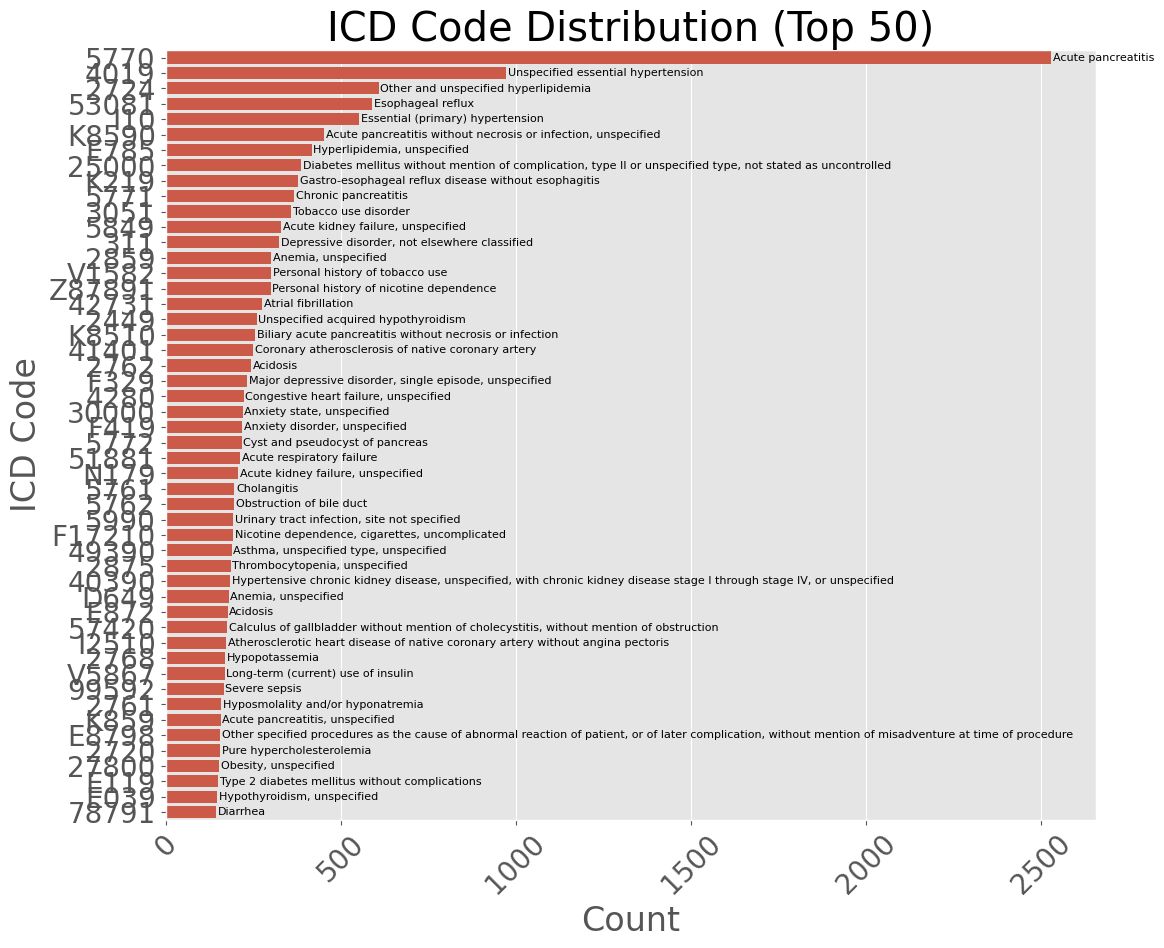

In [ ]:
icd_title_query = """
SELECT icd_code, icd_version, long_title
FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
"""
icd_titles_df = run_query(icd_title_query)

merged_comorbidities_df = pd.merge(merged_comorbidities_df, icd_titles_df, on=['icd_code', 'icd_version'], how='left')

plt.figure(figsize=(12, 10))
ax = sns.countplot(y='icd_code',
                   data=merged_comorbidities_df,
                   order=merged_comorbidities_df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')

for index, patch in enumerate(ax.patches):
    icd_code = merged_comorbidities_df['icd_code'].value_counts().index[:50][index]
    long_title = merged_comorbidities_df.loc[merged_comorbidities_df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', fontsize=8, color='black')

plt.xticks(rotation=45)
plt.show()